In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

divyamsareen_vr_project_path = kagglehub.dataset_download('divyamsareen/vr-project')

print('Data source import complete.')


100%|██████████| 2.10G/2.10G [01:48<00:00, 20.7MB/s]

Extracting files...


Data source import complete.


In [4]:
!pip install opencv-python

In [5]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

In [6]:
# prompt: check if my pytorch code is able to access the gpu

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device


True
Tesla T4


device(type='cuda')

In [7]:
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (3, 256, 256)  # channel-first
BATCH_SIZE = 4
EPOCHS = 30

# -----------------------
# Data Loading Functions
# -----------------------
def load_data(folder_path):
    filenames = os.listdir(folder_path)
    images = []
    for filename in filenames:
        if filename not in ["000601_1.jpg"]:
            images.append(filename)
    images = sorted(images)
    return np.array(images)

image_filenames = load_data(divyamsareen_vr_project_path+"/MSFD/1/face_crop")
mask_filenames = load_data(divyamsareen_vr_project_path+"/MSFD/1/face_crop_segmentation")

for i, (actual, mask) in enumerate(zip(image_filenames, mask_filenames)):
    if actual != mask:
        print(actual, mask)
        break

[7265, 1276, 125, 8342, 1894]
006557_1.jpg 006557_1.jpg
001034_1.jpg 001034_1.jpg
000094_1.jpg 000094_1.jpg
007373_4.jpg 007373_4.jpg
001483_1.jpg 001483_1.jpg


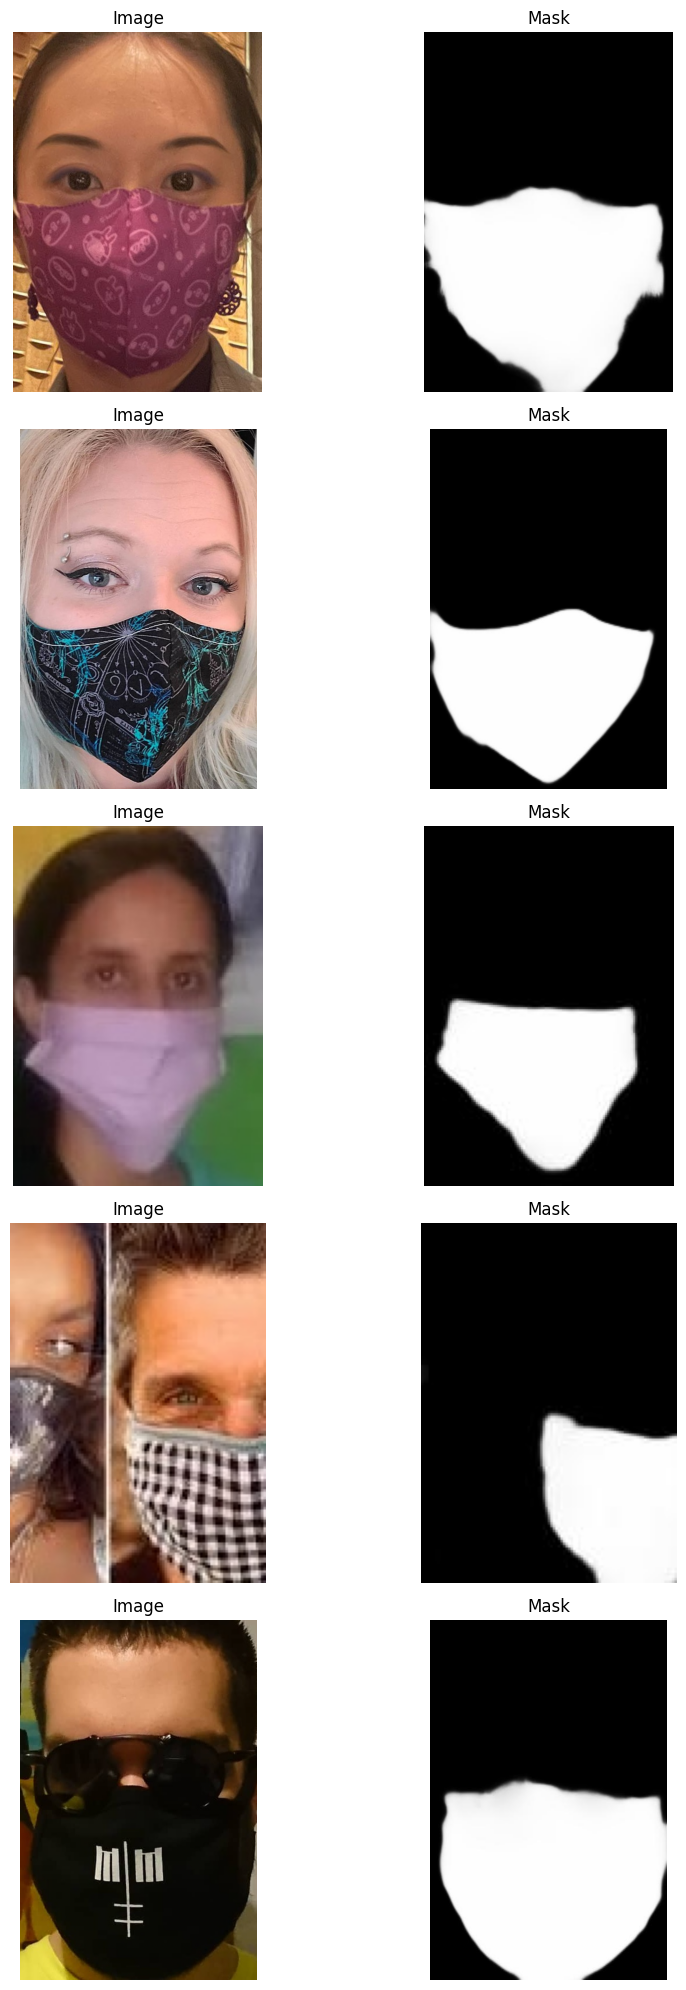

In [8]:
def display_data(actual_img, mask_img, image_paths, mask_paths):
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = plt.imread(os.path.join(actual_img, image_path))
        mask = plt.imread(os.path.join(mask_img, mask_path))
        print(image_path, mask_path)
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

indices = random.sample(range(0, len(image_filenames)), 5)
print(indices)
display_data(divyamsareen_vr_project_path+"/MSFD/1/face_crop/", divyamsareen_vr_project_path+"/MSFD/1/face_crop_segmentation/", image_filenames[indices], mask_filenames[indices])

In [9]:
# -------------------------------
# PyTorch Dataset and Preprocessing
# -------------------------------
class FaceDataset(Dataset):
    def __init__(self, actual_img_dir, mask_img_dir, image_names, mask_names, input_size, augmented):
        self.actual_img_dir = actual_img_dir
        self.mask_img_dir = mask_img_dir
        self.image_names = image_names
        self.mask_names = mask_names
        self.input_size = input_size
        self.augmented = augmented

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.actual_img_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_img_dir, self.mask_names[idx])
        img = Image.open(img_path).convert('RGB').resize(self.input_size)
        mask = Image.open(mask_path).convert('L').resize(self.input_size)

        img_array = np.array(img, dtype=np.float32) / 255.0  # (H, W, 3)
        mask_array = np.array(mask, dtype=bool).astype(np.float32)  # (H, W)

        # Convert HWC to CHW
        img_array = np.transpose(img_array, (2, 0, 1))
        mask_array = np.expand_dims(mask_array, axis=0)

        images = [img_array]
        masks = [mask_array]

        if self.augmented:
            img_hflip = np.flip(img_array, axis=2).copy()
            mask_hflip = np.flip(mask_array, axis=2).copy()
            images.append(img_hflip)
            masks.append(mask_hflip)

            img_vflip = np.flip(img_array, axis=1).copy()
            mask_vflip = np.flip(mask_array, axis=1).copy()
            images.append(img_vflip)
            masks.append(mask_vflip)

        return torch.tensor(images[0], dtype=torch.float32), torch.tensor(masks[0], dtype=torch.float32)

# Create dataset and split indices
all_dataset = FaceDataset(divyamsareen_vr_project_path+"/MSFD/1/face_crop/", divyamsareen_vr_project_path+"/MSFD/1/face_crop_segmentation/",
                          image_filenames, mask_filenames, INPUT_SIZE, True)
all_indices = np.arange(len(all_dataset))
train_val_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=47)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=47)

In [10]:
BATCH_SIZE=4
def subset_dataset(dataset, indices):
    subset_images = [dataset.image_names[i] for i in indices]
    subset_masks = [dataset.mask_names[i] for i in indices]
    return FaceDataset(dataset.actual_img_dir, dataset.mask_img_dir, subset_images, subset_masks, dataset.input_size, True)

train_dataset = subset_dataset(all_dataset, train_idx)
val_dataset   = subset_dataset(all_dataset, val_idx)
test_dataset  = subset_dataset(all_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 6004
Validation dataset size: 1501
Test dataset size: 1877


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

# Model checkpoint and learning rate scheduler (PyTorch implementation)
# (Checkpointing is done manually in the training loop and the scheduler is defined below)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.float()  # Convert y_true to float32
    y_pred = y_pred.float()
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = nn.BCELoss()(y_pred, y_true)
    return bce + dice_loss(y_true, y_pred)

class UNet(nn.Module):
    def __init__(self, input_channels, output_layer):
        super(UNet, self).__init__()
        # Encoder
        self.conv1_1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        # Bottom
        self.conv5_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(256)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(256)
        self.dropout5 = nn.Dropout(0.3)

        # Decoder
        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dropout6 = nn.Dropout(0.2)
        self.conv6_1 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1)
        self.bn6_1 = nn.BatchNorm2d(128)
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(128)

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dropout7 = nn.Dropout(0.2)
        self.conv7_1 = nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1)
        self.bn7_1 = nn.BatchNorm2d(64)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(64)

        self.up8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dropout8 = nn.Dropout(0.1)
        self.conv8_1 = nn.Conv2d(32 + 32, 32, kernel_size=3, padding=1)
        self.bn8_1 = nn.BatchNorm2d(32)
        self.conv8_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn8_2 = nn.BatchNorm2d(32)

        self.up9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.dropout9 = nn.Dropout(0.1)
        self.conv9_1 = nn.Conv2d(16 + 16, 16, kernel_size=3, padding=1)
        self.bn9_1 = nn.BatchNorm2d(16)
        self.conv9_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn9_2 = nn.BatchNorm2d(16)

        # Output
        self.out_conv = nn.Conv2d(16, output_layer, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.bn1_1(self.conv1_1(x)))
        conv1 = F.relu(self.bn1_2(self.conv1_2(conv1)))
        conv1 = self.dropout1(conv1)
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.bn2_1(self.conv2_1(pool1)))
        conv2 = F.relu(self.bn2_2(self.conv2_2(conv2)))
        pool2 = self.pool2(conv2)
        conv2 = self.dropout2(conv2)

        conv3 = F.relu(self.bn3_1(self.conv3_1(pool2)))
        conv3 = F.relu(self.bn3_2(self.conv3_2(conv3)))
        pool3 = self.pool3(conv3)
        conv3 = self.dropout3(conv3)

        conv4 = F.relu(self.bn4_1(self.conv4_1(pool3)))
        conv4 = F.relu(self.bn4_2(self.conv4_2(conv4)))
        pool4 = self.pool4(conv4)
        conv4 = self.dropout4(conv4)

        # Bottom
        conv5 = F.relu(self.bn5_1(self.conv5_1(pool4)))
        conv5 = F.relu(self.bn5_2(self.conv5_2(conv5)))
        conv5 = self.dropout5(conv5)

        # Decoder
        up6 = self.up6(conv5)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.dropout6(merge6)
        conv6 = F.relu(self.bn6_1(self.conv6_1(conv6)))
        conv6 = F.relu(self.bn6_2(self.conv6_2(conv6)))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.dropout7(merge7)
        conv7 = F.relu(self.bn7_1(self.conv7_1(conv7)))
        conv7 = F.relu(self.bn7_2(self.conv7_2(conv7)))

        up8 = self.up8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.dropout8(merge8)
        conv8 = F.relu(self.bn8_1(self.conv8_1(conv8)))
        conv8 = F.relu(self.bn8_2(self.conv8_2(conv8)))

        up9 = self.up9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.dropout9(merge9)
        conv9 = F.relu(self.bn9_1(self.conv9_1(conv9)))
        conv9 = F.relu(self.bn9_2(self.conv9_2(conv9)))

        # Output
        output = torch.sigmoid(self.out_conv(conv9))
        return output

# Instantiate model
# INPUT_SHAPE: assume it's a tuple like (channels, height, width)
INPUT_SHAPE = (3, 256, 256)  # Example input shape, change as needed
model = UNet(input_channels=INPUT_SHAPE[0], output_layer=1)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=1/5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# -------------------------------
# Training Loop
# -------------------------------
epochs=30
best_val_loss = float("inf")
save_path = "models/save_best.pth"
os.makedirs("models", exist_ok=True)

# Move the model to the GPU if available
if torch.cuda.is_available():
  model = model.to(device)  # Use 'device' to ensure consistency
  print("Model moved to GPU")

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    for imgs, masks in train_loader:
        # Move data to the same device as the model
        imgs = imgs.to(device)  # Use 'device' to ensure consistency
        masks = masks.to(device) # Use 'device' to ensure consistency

        optimizer.zero_grad()
        outputs = model(imgs)

        # Ensure loss calculation also happens on the device
        loss = bce_dice_loss(masks, outputs).to(device)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_dice += dice_coefficient(masks, outputs).item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    train_dice /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            # Move data to the same device as the model
            imgs = imgs.to(device) # Use 'device' to ensure consistency
            masks = masks.to(device) # Use 'device' to ensure consistency
            outputs = model(imgs)

            # Ensure loss calculation also happens on the device
            loss = bce_dice_loss(masks, outputs).to(device)

            val_loss += loss.item() * imgs.size(0)
            val_dice += dice_coefficient(masks, outputs).item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_dice /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f} - Val Loss: {val_loss:.4f} - Val Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model.")

    lr_scheduler.step(val_loss)

Model moved to GPU


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30 - Train Loss: 0.4741 - Train Dice: 0.7861 - Val Loss: 0.2854 - Val Dice: 0.8736
Saved best model.
Epoch 2/30 - Train Loss: 0.2601 - Train Dice: 0.8917 - Val Loss: 0.2209 - Val Dice: 0.9096
Saved best model.
Epoch 3/30 - Train Loss: 0.2255 - Train Dice: 0.9093 - Val Loss: 0.2072 - Val Dice: 0.9149
Saved best model.
Epoch 4/30 - Train Loss: 0.2059 - Train Dice: 0.9179 - Val Loss: 0.2028 - Val Dice: 0.9178
Saved best model.
Epoch 5/30 - Train Loss: 0.1960 - Train Dice: 0.9223 - Val Loss: 0.1935 - Val Dice: 0.9196
Saved best model.
Epoch 6/30 - Train Loss: 0.1895 - Train Dice: 0.9249 - Val Loss: 0.2009 - Val Dice: 0.9205
Epoch 7/30 - Train Loss: 0.1827 - Train Dice: 0.9272 - Val Loss: 0.1826 - Val Dice: 0.9238
Saved best model.
Epoch 8/30 - Train Loss: 0.1775 - Train Dice: 0.9294 - Val Loss: 0.1834 - Val Dice: 0.9256
Epoch 9/30 - Train Loss: 0.1713 - Train Dice: 0.9316 - Val Loss: 0.1788 - Val Dice: 0.9284
Saved best model.
Epoch 10/30 - Train Loss: 0.1658 - Train Dice: 0.9337 -

In [13]:
# Load the best saved model
best_model = UNet(input_channels=3, output_layer=1).to(device)
best_model.load_state_dict(torch.load(save_path, map_location=device))
best_model.eval()
torch.save(best_model, "models/mask_model.pth")

In [14]:
# -------------------------------
# Evaluate on Test Set
# -------------------------------
test_loss = 0.0
dice_scores = []
all_preds = []
all_targets = []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        outputs = best_model(imgs)
        loss = bce_dice_loss(masks, outputs).to(device)
        test_loss += loss.item() * imgs.size(0)
        preds = (outputs > 0.5).float()
        for pred, target in zip(preds, masks):
            dice = dice_coefficient(pred, target).item()
            dice_scores.append(dice)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

test_loss /= len(test_loader.dataset)
avg_dice = np.mean(dice_scores)
print(f"Test Loss: {test_loss:.4f}, Test Dice Coefficient: {avg_dice:.4f}")

Test Loss: 0.1682, Test Dice Coefficient: 0.9450


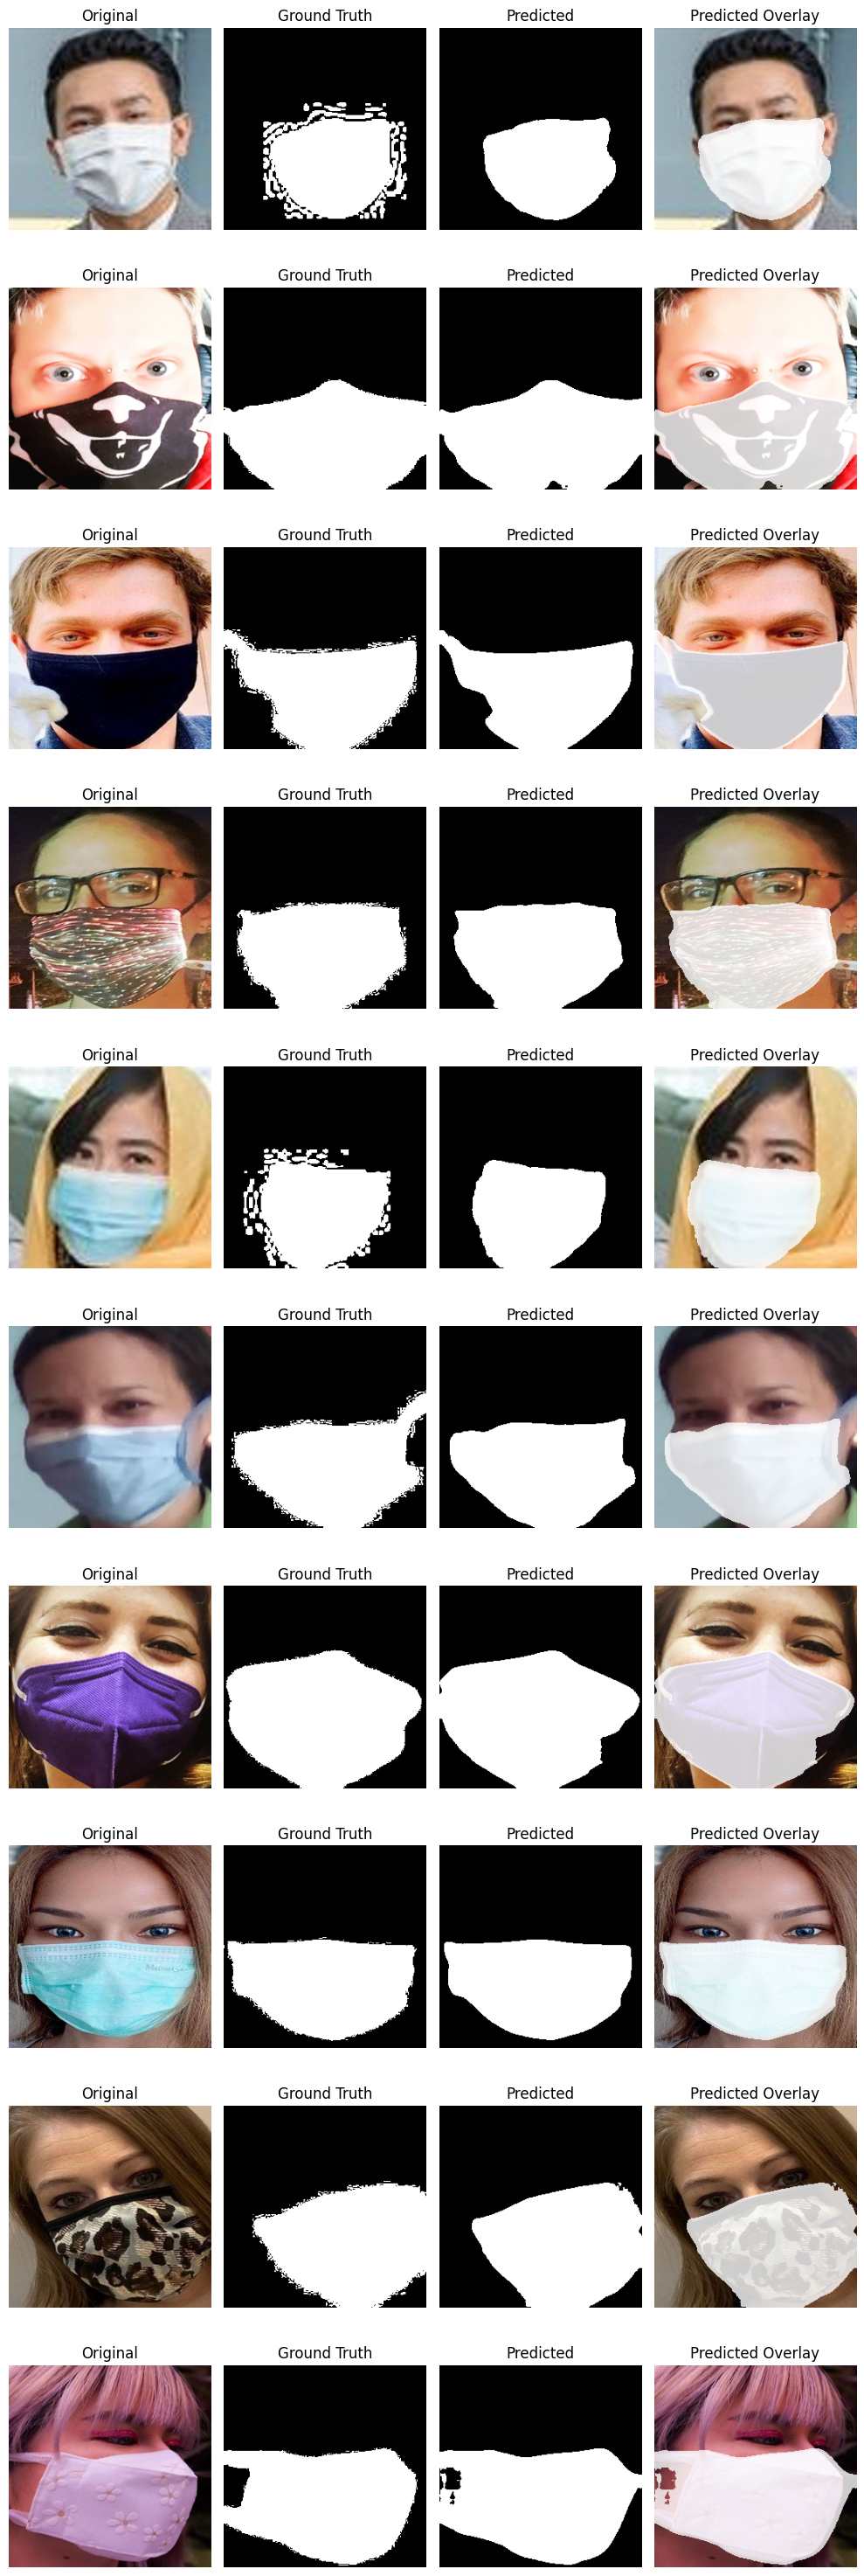

In [15]:
# -------------------------------
# Display 10 Random Predictions
# -------------------------------
test_images = []
test_masks = []
with torch.no_grad():
    for imgs, masks in test_loader:
        test_images.append(imgs.cpu().numpy())
        test_masks.append(masks.cpu().numpy())
test_images = np.concatenate(test_images, axis=0)
test_masks = np.concatenate(test_masks, axis=0)

#***CHANGE START***
predictions = []
with torch.no_grad():
    for i in range(0, len(test_images), BATCH_SIZE): # Process in batches
        batch_images = torch.tensor(test_images[i:i + BATCH_SIZE]).to(device)
        batch_preds = best_model(batch_images)
        batch_preds = (batch_preds > 0.5).float()
        predictions.extend(batch_preds.cpu().numpy())
predictions = np.array(predictions)
#***CHANGE END***

fig, axes = plt.subplots(10, 4, figsize=(10, 30))
for i in range(10):
    image = (np.transpose(test_images[i], (1, 2, 0)) * 255).astype(np.uint8)
    mask = predictions[i][0]
    ground_truth = test_masks[i][0] * 255

    overlay = image.copy()
    mask_3c = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    inverted_mask = 1 - mask_3c
    yellow_mask = np.array([255, 255, 255]) * mask_3c
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(yellow_mask.astype(np.uint8))
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(predicted_overlay.astype(np.uint8))
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')
plt.show()

In [16]:
# -------------------------------
# Compute Metrics
# -------------------------------
def flatten_masks(masks):
    return masks.reshape(masks.shape[0], -1)

def dice_score_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

flat_predictions = flatten_masks((predictions > 0.5).astype(np.uint8))
flat_test_masks = flatten_masks((test_masks > 0.5).astype(np.uint8))

total_accuracy = 0
total_precision = 0
total_recall = 0
total_iou = 0
total_dice = 0
num_samples = flat_predictions.shape[0]

for i in range(num_samples):
    y_true = flat_test_masks[i]
    y_pred = flat_predictions[i]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    iou = jaccard_score(y_true, y_pred, zero_division=0)
    dice = dice_score_np(y_true, y_pred)

    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_iou += iou
    total_dice += dice

avg_accuracy = total_accuracy / num_samples
avg_precision = total_precision / num_samples
avg_recall = total_recall / num_samples
avg_iou = total_iou / num_samples
avg_dice = total_dice / num_samples

print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average Dice Score: {avg_dice:.4f}')

Average Accuracy: 0.9603
Average Precision: 0.9515
Average Recall: 0.9420
Average IoU: 0.9011
Average Dice Score: 0.9450
